In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from green_city.utils import index2datetime
from green_city.regression import plot_ts, error_metrics, train_test_time_split
from green_city.regression import seasons, time_of_day, forecast_dates

#import warnings
#warnings.filterwarnings('ignore')

RSEED = 42

In [2]:
#def add_up(cols):
#    def add_up_cols(s):
#        net = sum([s[col] for col in cols])
#        return net
#    return add_up_cols

def load_external_features():
    ex_cols = [
        "pred_24h_outdoor_temp",
        "pred_24h_outdoor_hum",
        "pred_24h_diffuse_solar_W_m2",
        "pred_24h_direct_solar_W_m2",
    ]
    #pred_ex_cols = [f"pred_24h_{ec}" for ec in ex_cols]
    
    df = (
        pd.read_csv("../data/preprocessed/Building_1.csv")
        .astype({'datetime': 'datetime64'})
        .set_index('datetime')
    )
    df_external = df[ex_cols].shift(24, fill_value=0)
    #df_external_p24h = df[pred_ex_cols]

    #replacing the values in the last year with the respective predictions:
    ###TODO: currently using actual temp hum usw data
    #for col in df_external.columns:
    #    df_external.loc[df_external.index >= pd.Timestamp('2011-01-01'), col] = df_external_p24h[f"pred_24h_{col}"]

    df_external["holiday"] = df["holiday"]
    #add date information
    df_external = df_external.assign(
        hour =    df_external.index.hour,
        month =   df_external.index.month,
        weekday = df_external.index.weekday,
    )
    
    df_external['year_sin365'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df_external['year_cos365'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
    df_external['year_sin365_2'] = np.sin(4 * np.pi * df.index.dayofyear / 365)
    df_external['year_cos365_2'] = np.cos(4 * np.pi * df.index.dayofyear / 365)
    df_external['week_sin365'] = np.sin(2 * np.pi * df.index.dayofweek/7)
    df_external['week_cos365'] = np.cos(2 * np.pi * df.index.dayofweek/7)
    df_external['week_sin365_2'] = np.sin(4 * np.pi * df.index.dayofweek/7)
    df_external['week_cos365_2'] = np.cos(4 * np.pi * df.index.dayofweek/7)
    df_external['hour_sin365'] = np.sin(2 * np.pi * df.index.hour/24)
    df_external['hour_cos365'] = np.cos(2 * np.pi * df.index.hour/24) 
    df_external['hour_sin365_2'] = np.sin(4 * np.pi * df.index.hour/24)
    df_external['hour_cos365_2'] = np.cos(4 * np.pi * df.index.hour/24)
    
    #.apply(lambda x: [x.name.hour, x.name.month, x.name.weekday()], axis=1, result_type='expand')
    #.rename(columns={0: 'hour', 1: 'month', 2: 'weekday'})
    #)
    #df_external
    
    return df_external

def load_features(i, energy_usage_cols):
    df = (
        pd.read_csv(f"../data/preprocessed/Building_{i+1}.csv")
        .astype({'datetime': 'datetime64'})
        .set_index('datetime')
        .assign(neg_solar_generation_kW = lambda x: -x.solar_generation_kW,
                #my_net = add_up(energy_usage_cols),
        )[[*energy_usage_cols]]
    )
    return df

#for the last year we have to replace actual temp and hum with their 24h preds

energy_usage_cols = [
    'equipment_electric_power_kW',
    'dhw_heating_kW',
    'neg_solar_generation_kW',
    'electric_load_hp_kW',
]

#df["diff"] = df["my_net"] - df["net_load_kW"] #seems to be correct up to rounding


# Load data
dfs = [load_features(i, energy_usage_cols) for i in range(9)]

all_features = pd.DataFrame({(i, col): dfs[i][col] for i in range(9) for col in energy_usage_cols})
external_features = load_external_features()

#36 features to individually predict

# Create a prediction based on all buildings loads separately
- at the end the error can be split up to the individual buildings
- and to the individual components (is heating more miss-predicted then solar)?
- because
  + error_tot = error_1_tot + ... + error_9_tot and
  + error_1_tot = error_1_eqp + error_1_solar + error_1_heating + error_1_cooling
- The components for each building are:
  + `equipment_electric_power_kW + dhw_heating_kW + cooling_load_kW - solar_generation_kW + electric_load_hp_kW`
- second step: use weather etc. for predictions

In [3]:
def predict_target_col(df):
    dummy_features = ['hour', 'month', 'holiday', 'weekday']
    target = 'target'
    
    #add shifted columns for the previous day:
    #for i in [*list(range(24, 49)), 24*7]:
    for i in [24, 24*7]:
        df[f"target_shift_{i}"]= df.target.shift(i, fill_value=0)
    #df['net_load_kW_lag168'] = df['net_load_kW'].shift(24*7)
    
    features = [c for c in df.columns if not c == target]

    print(features)
    
    # Do train-test split
    X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                            df, features, target, 
                                                            dummy_features)
    
    # Create the model
    rf = RandomForestRegressor(random_state=RSEED)
    
    # Fit on training data
    rf.fit(X_train, y_train)
    
    # Predict train and test data
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    df_test['y_pred_test'] = y_pred_test
    
    # Calculate and print error metrics
    _ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")
    return y_pred_test                                           

# summing up all single components

In [4]:
predictions_df_dict = {}
for (b, f) in all_features.columns:
    building_nr = b
    feature_name = f
    target = all_features[(building_nr, feature_name)].rename("target")

    input_df = pd.concat([target, external_features], axis=1)

    #now we can start predicting
    predictions_df_dict[(b, f)] = predict_target_col(input_df)

['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.995
R2 (test) : 0.805
MAE (test): 3.328
MSE (test): 49.98
RMSE(test): 7.07
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 0.921
MAE (test): 0.126
MSE (test): 0.168
RMSE(test): 0.41
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 0.996
MAE (test): 0.884
MSE (test): 3.354
RMSE(test): 1.831
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.998
R2 (test) : 0.841
MAE (test): 9.015
MSE (test): 344.154
RMSE(test): 18.551
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.007
MSE (test): 0.005
RMSE(test): 0.067
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.999
R2 (test) : 0.983
MAE (test): 0.106
MSE (test): 0.279
RMSE(test): 0.528
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.0
MSE (test): 0.0
RMSE(test): 0.0
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_co

/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.998
R2 (test) : 0.978
MAE (test): 0.988
MSE (test): 2.639
RMSE(test): 1.624
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 0.962
MAE (test): 0.297
MSE (test): 0.571
RMSE(test): 0.756
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.0
MSE (test): 0.0
RMSE(test): 0.0
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos3

/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.0
MSE (test): 0.0
RMSE(test): 0.0
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.998
R2 (test) : 0.948
MAE (test): 3.55
MSE (test): 51.916
RMSE(test): 7.205
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 0.965
MAE (test): 0.147
MSE (test): 0.402
RMSE(test): 0.634
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.0
MSE (test): 0.0
RMSE(test): 0.0
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos3

/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 0.996
MAE (test): 0.295
MSE (test): 0.372
RMSE(test): 0.61
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.998
R2 (test) : 0.962
MAE (test): 2.911
MSE (test): 42.96
RMSE(test): 6.554
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.94
R2 (test) : 0.58
MAE (test): 1.48
MSE (test): 3.689
RMSE(test): 1.921
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.956
R2 (test) : 0.686
MAE (test): 1.79
MSE (test): 7.905
RMSE(test): 2.812
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 0.996
MAE (test): 0.184
MSE (test): 0.146
RMSE(test): 0.382
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.996
R2 (test) : 0.965
MAE (test): 1.358
MSE (test): 3.692
RMSE(test): 1.921
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.927
R2 (test) : 0.482
MAE (test): 1.656
MSE (test): 4.491
RMSE(test): 2.119
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.953
R2 (test) : 0.667
MAE (test): 1.701
MSE (test): 6.774
RMSE(test): 2.603
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 0.996
MAE (test): 0.147
MSE (test): 0.093
RMSE(test): 0.305
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.996
R2 (test) : 0.961
MAE (test): 1.356
MSE (test): 3.507
RMSE(test): 1.873
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.935
R2 (test) : 0.552
MAE (test): 1.942
MSE (test): 5.836
RMSE(test): 2.416
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.953
R2 (test) : 0.666
MAE (test): 1.582
MSE (test): 6.168
RMSE(test): 2.483
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.0
MSE (test): 0.0
RMSE(test): 0.0
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_co

/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.995
R2 (test) : 0.951
MAE (test): 1.511
MSE (test): 4.189
RMSE(test): 2.047
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.956
R2 (test) : 0.686
MAE (test): 1.17
MSE (test): 2.794
RMSE(test): 1.672
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.95
R2 (test) : 0.652
MAE (test): 1.596
MSE (test): 5.837
RMSE(test): 2.416
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.0
MSE (test): 0.0
RMSE(test): 0.0
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos

/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.995
R2 (test) : 0.951
MAE (test): 1.285
MSE (test): 3.408
RMSE(test): 1.846
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.967
R2 (test) : 0.76
MAE (test): 1.299
MSE (test): 3.264
RMSE(test): 1.807
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test
/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.95
R2 (test) : 0.655
MAE (test): 1.621
MSE (test): 5.971
RMSE(test): 2.443
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.0
MSE (test): 0.0
RMSE(test): 0.0
['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos

/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test


In [5]:
new_preds = pd.DataFrame({
    'pred': pd.DataFrame(predictions_df_dict).sum(axis=1),
    'datetime': pd.date_range('2011-01-01', '2011-12-31 23:00', freq='H'),
}).set_index('datetime')

total_net = (
    pd.read_csv("../data/preprocessed/Agg_buildings.csv")
    .astype({'datetime': 'datetime64'})
    .set_index('datetime')
    ["net_load_kW"]
)

new_preds["actual"] = total_net

22.531417523061794

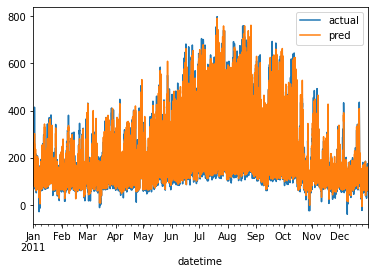

In [6]:
new_preds[["actual", "pred"]].plot()
mean_absolute_error(new_preds["pred"], new_preds["actual"])

# only total net

['pred_24h_outdoor_temp', 'pred_24h_outdoor_hum', 'pred_24h_diffuse_solar_W_m2', 'pred_24h_direct_solar_W_m2', 'holiday', 'hour', 'month', 'weekday', 'year_sin365', 'year_cos365', 'year_sin365_2', 'year_cos365_2', 'week_sin365', 'week_cos365', 'week_sin365_2', 'week_cos365_2', 'hour_sin365', 'hour_cos365', 'hour_sin365_2', 'hour_cos365_2', 'target_shift_24', 'target_shift_168']


/Users/rafaelarndt/capstone/TheGreenCitySolutionsGroup/notebooks/green_city/regression.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.997
R2 (test) : 0.919
MAE (test): 28.402
MSE (test): 1966.354
RMSE(test): 44.344


/var/folders/_t/s3471w991f75_hmpcmrkm6qm0000gn/T/ipykernel_82214/2737797881.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_test'] = y_pred_test


28.40237531392694

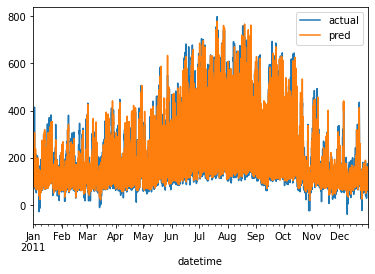

In [7]:
#directly predict net usage:
input_df = pd.concat([total_net, external_features], axis=1).rename(columns={'net_load_kW': 'target'})

#now we can start predicting
net_prediction = predict_target_col(input_df)
net_pred_df = pd.DataFrame({
    'pred': net_prediction,
    'datetime': pd.date_range('2011-01-01', '2011-12-31 23:00', freq='H'),
}).set_index('datetime')

net_pred_df["actual"] = total_net

net_pred_df[["actual", "pred"]].plot()
mean_absolute_error(net_pred_df["pred"], net_pred_df["actual"])

# using component predictions as additional inputs
- for this I have to predict in the train years as well, where the error may be different.